# Generates the readout's coefficients 
## It uses the simulation output from created in the notebook: BEE_Simulator_ArmControl_VREP_LSM_DATA-GENERATOR.ipynb

### The linear regression shows us that it's important to have a good learning here (seen through the generated curves using the calculated weights on the training set), but a good learning DOES NOT guaranties a good performance during the testing phase.

In [1]:
# Makes possible to show the output from matplotlib inline
%matplotlib inline

import matplotlib.pyplot as plt

# Makes the figures in the PNG format:
# For more information see %config InlineBackend
%config InlineBackend.figure_formats=set([u'png'])

plt.rcParams['figure.figsize'] = 5, 10

import numpy
import sys
import os

from sklearn import linear_model

import save_load_file as slf

import membrane_lowpass_md
membrane_lowpass = membrane_lowpass_md.membrane_lowpass

import time

In [2]:
# Loads the modules and starts the object to be used with the parallel processing iPython stuff...

# Remember to start the clusters:
# https://ipyparallel.readthedocs.org/en/latest/process.html

#from ipyparallel import Client

#cli = Client()

#lbview = cli.load_balanced_view()
# dview = cli[:]

In [3]:
#
# Controls if the results are saved to a file
#

save2file = True

In [4]:
#
# This is the low-pass filter (neuron membrane) applied to the outputs:
membrane_time_constant = 30E-3

# Reducing this value reduces the "memory" of the membrane.

NofN = 8*5*5 # total number of neurons in the output
sim_step_time = 2E-3 #simulation step time (in seconds)

#simulation type
platform = "realBaxter"
trial_number = 0
total_trials = 100

#
# Controls if the results are saved to a file
#
save2file = True

#simulation type
#platform = "gazeboBaxter"
platform = "realBaxter"

##--data filenames--
input_filename = "XY_movement_square_+0.5cm"
#input_filename = "XY_movement_square_HIGHTABLE3_free"

input_folder = "PIDs_DATA_FOR_THE_LSM"
data_folder = "PIDs_LSM"
sim_type = "with_PID_0.5cm"

total_trials_available = 100

number_of_trajectories = 1

disconnected = False

size_distr=10000

In [5]:
trial_array = numpy.arange(0,total_trials_available,dtype=numpy.int)
# numpy.random.shuffle(trial_array)

In [6]:
#
# Creates a function to read the spikes in a (multiple process) parallel way.
#
#@lbview.parallel(block=True)
def reads_files(filename):
    import save_load_file as slf 
    return slf.load_from_file_gz(filename)

In [7]:
#
# Here the liquid index is defined
#
# REMEMBER: it goes from ZERO to (number_of_liquids-1)

lsm_i = 4

In [8]:
%%time
# 
# Loads the spikes generated by the liquid with index=lsm_i
# 

filenames = []
output_spikes_simulation = []
for pos_i in xrange(number_of_trajectories):
    for run_i in trial_array[:total_trials]:
        filenames.append(os.getcwd()+"/"+data_folder+"/"+"sensors_LSM_"+str(lsm_i)+"_"+str(run_i)+".gzpickle")
        # The format of simulated_values is (a list of tuples):
        # [
        # current time (in ms),    =>index 1
        # numpy.array with spikes, =>index 2
        # ]
    output_spikes_simulation.append(map(reads_files,filenames))

CPU times: user 8.17 s, sys: 24 ms, total: 8.2 s
Wall time: 8.18 s


In [9]:
# 
# Prints some values (first and last time steps), just to make sure it worked...
#

print output_spikes_simulation[0][0][0]

print output_spikes_simulation[0][-1][-1]

[0, array([], dtype=int32)]
[1.9980000000000016, array([  9,  10,  13,  26,  30,  33,  37,  47,  49,  52,  65,  67,  70,
        75,  83,  84,  91,  92, 101, 102, 103, 106, 109, 110, 111, 112,
       117, 119, 120, 123, 129, 135, 149, 150, 156, 160, 161, 164, 166,
       169, 171, 172, 173, 174, 177, 179, 181, 182], dtype=int32)]


## Information about the simulation is extracted directly from data:
```output_spikes_simulation[X] => all the simulated values for the trajectory X+1
output_spikes_simulation[X][Y] => the simulated values for trial Y+1 of the trajectory X+1
output_spikes_simulation[X][Y][Z] => the output spikes for the step Z of the simulated values 
                                     for trial Y+1 of the trajectory X+1
total_trajectories => len(output_spikes_simulation)
total_trials => len(output_spikes_simulation[0]),
total_steps => len(output_spikes_simulation[0][0][:])
sim_step_time => (output_spikes_simulation[0][0][1][0]-output_spikes_simulation[0][0][0][0])```


In [10]:
total_trajectories,total_trials,total_steps,sim_step_time = len(output_spikes_simulation),len(output_spikes_simulation[0]),len(output_spikes_simulation[0][0]), (output_spikes_simulation[0][0][1][0]-output_spikes_simulation[0][0][0][0])
total_trajectories,total_trials,total_steps,sim_step_time

(1, 100, 1000, 0.002)

In [11]:
%%time
# Generates the FILTERED (membrane low-pass filter) data to be used with the linear regression

# The first index of the matrix is the trajectory
# Example (each trajectory has 250 steps): 
# linalg_matrix_filtered[0][0:250] => is the first experiment of the first trajectory
# linalg_matrix_filtered[0][250:250*2] => is the second experiment of the first trajectory

avoid_n = 0 # Avoids the avoid_n steps after step=0 (always ignored)
            # This type of LSM receives during the first N steps the correct values before it
            # starts generating the rest of the time series.
            # N = avoid_n+1

# t_idx = 0 # 0=>first trajectory
# e_idx = 0 # 0=>first experiment
linalg_matrix_filtered = numpy.zeros((total_trajectories, total_trials*(total_steps-avoid_n), NofN),dtype=numpy.float)

for t_idx in range(total_trajectories): # goes through all the trajectories
    for e_idx in range(total_trials): # goes through all the trials
        m_v=membrane_lowpass(NofN,membrane_time_constant) # Initialize the membrane for each new trial
        for i in range(1,total_steps): # ignores the first output from the network (noisy, uncorrelated with input)
            if (output_spikes_simulation[t_idx][e_idx][i][1]).size>0:
                m_v.process_spikes(output_spikes_simulation[t_idx][e_idx][i][1],\
                                   output_spikes_simulation[t_idx][e_idx][i][0])
            if i >= avoid_n: #useless as i starts at 1 and avoid_n=1...
                linalg_matrix_filtered[t_idx][(i-avoid_n)+\
                                              (total_steps-avoid_n)*e_idx]=m_v.check_values(i*sim_step_time) # Saves the membrane state at each time step


# This is another good candidate to be vectorized...

CPU times: user 6.15 s, sys: 8 ms, total: 6.16 s
Wall time: 6.16 s


In [12]:
print linalg_matrix_filtered.shape

(1, 100000, 200)


# Defines the outputs to be learned

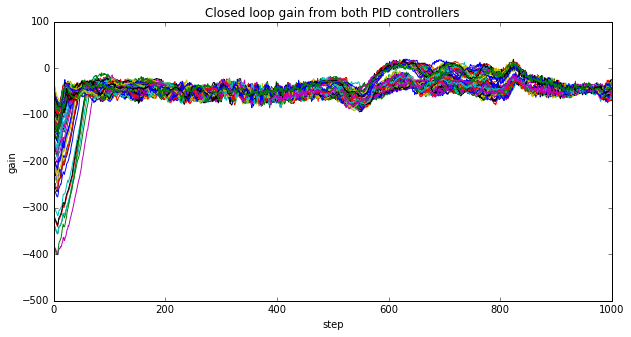

In [13]:
pid_hist=numpy.ndarray((total_trials,1000))

plt.figure(figsize=(10,5))
for trial_number in range(total_trials):
    #reads stuff
    pidF_hist=numpy.copy(numpy.load(input_folder+"/"+sim_type+"PID_Force_hist_trial"+str(trial_number)+".npy"))
    pidR_hist=numpy.copy(numpy.load(input_folder+"/"+sim_type+"PID_Range_hist_trial"+str(trial_number)+".npy"))
    pid_hist[trial_number] =  pidF_hist+pidR_hist
    plt.plot(pid_hist[trial_number])
plt.title("Closed loop gain from both PID controllers")
plt.ylabel("gain")
plt.xlabel("step")
plt.show()

In [14]:
pid_hist.shape

(100, 1000)

Now I need to read the CORRECT joint values to be used with the linear regression

In [15]:
y_sensor = []
for ti in range(total_trials):
        y_sensor=numpy.concatenate((y_sensor,pid_hist[ti]))
print y_sensor.shape

(100000,)


# Uses the low-pass filtered outputs:

In [16]:
X_matrix=linalg_matrix_filtered    

In [17]:
X_matrix.shape

(1, 100000, 200)

In [18]:
# Prepare the matrix to be used with numpy linear regression:
X_reshaped=X_matrix.reshape(y_sensor.shape[0],NofN)

# Creates an empty matrix with an extra collumn with ones (numpy.linalg.lstsq demands this...)
X_reshaped=numpy.ones((X_reshaped.shape[0],X_reshaped.shape[1]+1))

# Writes the values in to the first NofN collumns
X_reshaped[:,:NofN]=X_matrix.reshape(y_sensor.shape[0],NofN)


In [19]:
# Now the reshaped matrix has an extra collumn:
X_reshaped.shape

(100000, 201)

In [20]:
X=X_reshaped

In [21]:
numpy.shape(X)[0]*numpy.shape(X)[1]

20100000

In [22]:
X.max(),X.min(),y_sensor.max(),y_sensor.min()

(8.0111078203233479, 0.0, 20.056883029254436, -400.9080698986582)

In [23]:
X.shape, y_sensor.shape

((100000, 201), (100000,))

In [24]:
X[:,-1] # Shows the last column made of ones...

array([ 1.,  1.,  1., ...,  1.,  1.,  1.])

In [25]:
filename = "./"+data_folder+"/"+"sensors_LSM_"+str(lsm_i)+".gzpickle"
print filename

./PIDs_LSM/sensors_LSM_4.gzpickle


In [26]:

%%time

# Non parallel linear regression (trying to solve the pickles problem when I have too many trials (more than 300...))
from sklearn import linear_model

X=X[:,:NofN] # Cuts out the extra ones used only for 

sklg = linear_model.Ridge()
y=y_sensor.T

sklg.fit(X,y)

CPU times: user 672 ms, sys: 616 ms, total: 1.29 s
Wall time: 700 ms


In [27]:
sklg.intercept_

-135.57819116140178

In [28]:
if save2file:
    slf.save_to_file([sklg.coef_,sklg.intercept_],filename)
[c_sensors,r_sensors] = slf.load_from_file(filename)

#### Using sklearn I can try a lot of different readouts:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

In [29]:
s_calculated=X_matrix.reshape(y_sensor.shape[0],NofN).dot(c_sensors)+r_sensors

In [30]:
X_matrix.shape

(1, 100000, 200)

In [31]:
# This dictionary is used to automate the figures generation
joints_dict={'PID':(y_sensor,s_calculated) }

In [32]:
# Plots the inputs and the outputs side-by-side

lsm_out = 'PID'

y_1 = joints_dict[lsm_out][0]
y1_calculated = joints_dict[lsm_out][1]

offset11 = y_1.shape[0]/number_of_trajectories
offset12 = y_1.shape[0]/number_of_trajectories/total_trials
print offset11,offset12

100000 1000


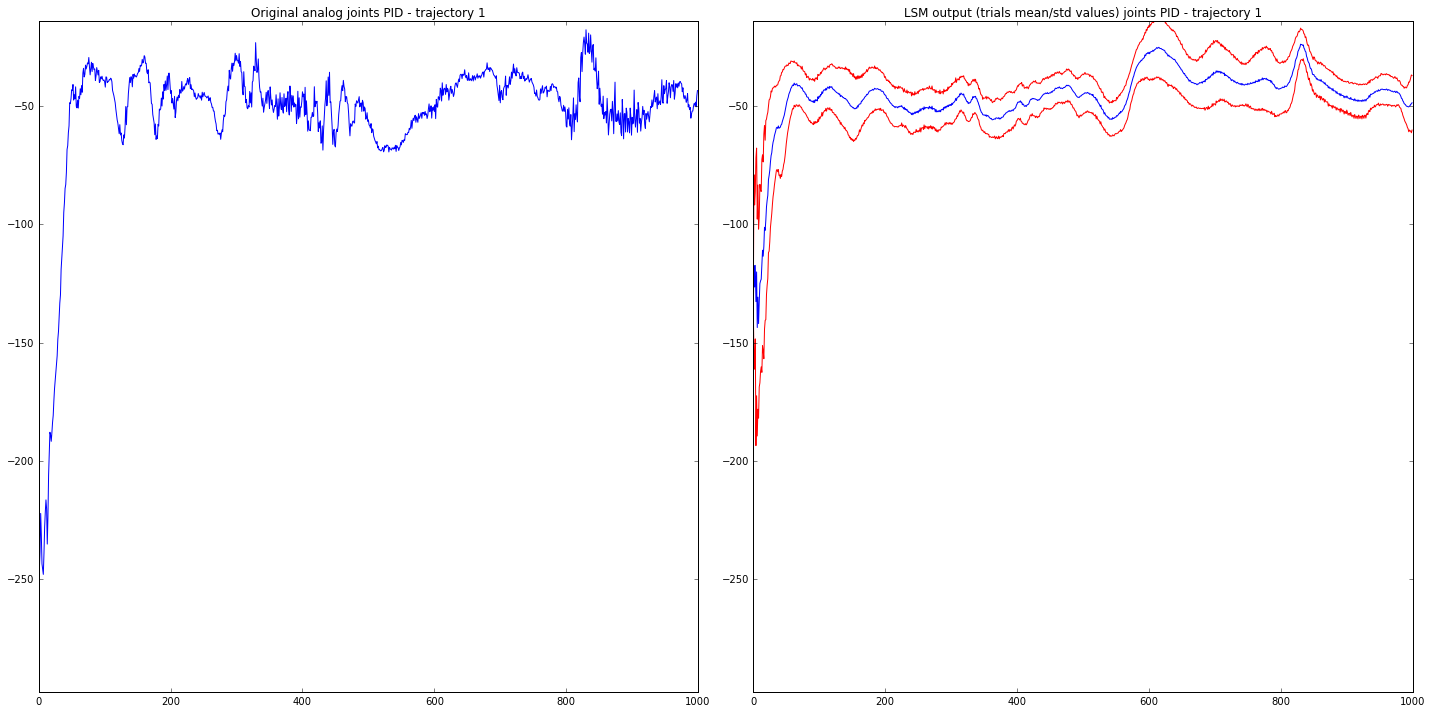

In [33]:
fig=plt.figure(figsize =(20,10));

for trajectory in xrange(number_of_trajectories):
# trajectory=0 # goes from 0 to 3

    ymax=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    ymin=numpy.array([y_1[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()

    ymaxLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].max()]).max()
    yminLSM=numpy.array([y1_calculated[trajectory*(total_trials*total_steps):total_steps*(1+trajectory*(total_trials*total_steps))].min()]).min()


    plt.subplot(number_of_trajectories,2,2*trajectory+1)    
    plt.plot(y_1[trajectory*(offset11):offset11*trajectory+offset12],'b')

    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("Original analog joints "+ str(lsm_out) +" - trajectory " + str(trajectory+1))

    plt.subplot(number_of_trajectories,2,2*trajectory+2)
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)+y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0)-y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].std(axis=0),'r')    
    plt.plot(y1_calculated.reshape(number_of_trajectories,total_trials,total_steps-avoid_n)[trajectory,:,:].mean(axis=0),'b')    
    plt.ylim(ymin-abs(ymin)/5.,ymax+abs(ymax)/5.)
    plt.title("LSM output (trials mean/std values) joints "+ str(lsm_out) +" - trajectory " + str(trajectory+1))

# fig.subplots_adjust(bottom=0,hspace=.6) # Adjust the distance between subplots
plt.tight_layout()
# plt.savefig("./"+base_dir+"/"+sim_set+"/readout_test_s0_s1_"+sim_set+".pdf")
plt.show()

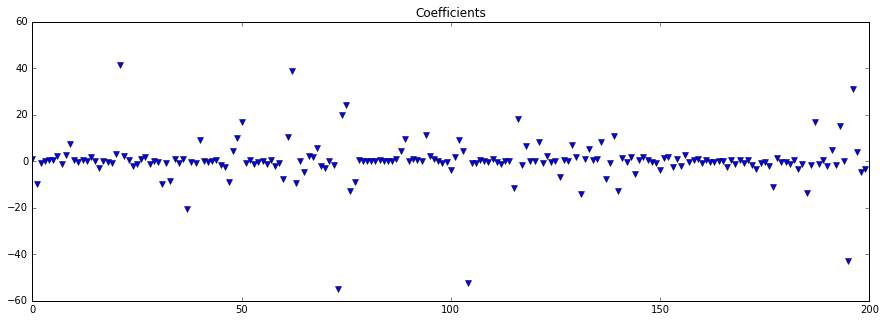

In [34]:
plt.figure(figsize=(15,5))
plt.plot(c_sensors,'v')
plt.title("Coefficients")
plt.show()


In [35]:
# Independent terms
r_sensors
# Independent terms close to zero are the result of the bias extraction (I force the curves to start at zero)

-135.57819116140178